In [ ]:
# TO DO:
# add batch_normalization layer

# try with flattened inputs ?

In [ ]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
import keras.backend as K
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split
from glob import glob
import math
#%matplotlib inline

In [ ]:
import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [4]:
# import data
imagePatches = glob('datasets/breast-histopathology/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2251_y1951_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1951_y2201_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2001_y2151_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1901_y2751_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2201_y2001_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1501_y2651_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2201_y2701_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2051_y2001_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1701_y2701_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2401_y2701_class1.png


In [5]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [24]:
sampled_class0 = random.sample(class0, 78786)
sampled_class1 = random.sample(class1, 78786)
#sampled_class0 = random.sample(class0, 50000)
#sampled_class1 = random.sample(class1, 50000)
#sampled_class0 = random.sample(class0, 1000)
#sampled_class1 = random.sample(class1, 1000)
len(sampled_class0)

1000

In [7]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), #was (70,70)
                        interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label]) 
    return img_arrays

In [8]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [26]:
combined_data = np.concatenate((class0_array, class1_array))
#random.seed(41)
#random.shuffle(combined_data)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [27]:
X = []
y = []

for features, label in combined_data:
    X.append(features)
    y.append(label)

In [28]:
X = np.array(X).reshape(-1, 50, 50, 3)
y = np.array(y)

print(X.shape)
print(y.shape)

(100000, 50, 50, 3)
(100000,)


In [29]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2,
                                    random_state = 11)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
                            test_size = 0.25, random_state = 11) 
                            # 0.25 x 0.8 = 0.2
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
val_y = to_categorical(val_y)
train_y_label = np.argmax(train_y, axis=1) # from one-hot encoding to integer
test_y_label = np.argmax(test_y, axis=1)
val_y_label = np.argmax(val_y, axis=1)
class_names = ('non-cancer','cancer')
print(train_x.shape, test_x.shape, val_x.shape, train_y.shape, test_y.shape, val_y.shape)

(60000, 50, 50, 3) (20000, 50, 50, 3) (20000, 50, 50, 3) (60000, 2) (20000, 2) (20000, 2)


In [30]:
print('Min value: ', train_x.min())
print('Max value: ', train_x.max())

Min value:  0
Max value:  255


In [31]:
train_x = train_x / 255
test_x = test_x / 255
val_x = val_x / 255
print('Min value: ', train_x.min())
print('Max value: ', train_x.max())

Min value:  0.0
Max value:  1.0


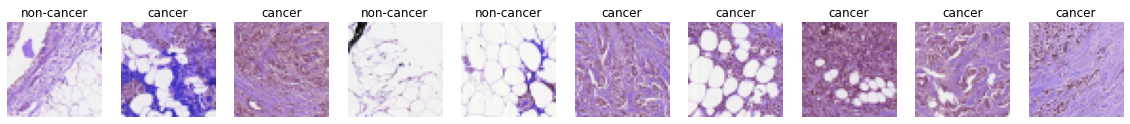

In [32]:
# visualize random images from data
image_count = 10

_, axs = plt.subplots(1, image_count, figsize=(20, 20))
for i in range(image_count):
  random_idx=random.randint(0, train_x.shape[0])
  axs[i].imshow(train_x[random_idx], cmap='gray')
  axs[i].axis('off')
  axs[i].set_title(class_names[train_y_label[random_idx]])

In [16]:
#vae = keras.models.load_model('models/vae.h5')
#encoder = keras.models.load_model('models/encoder.h5')
#decoder = keras.models.load_model('models/decoder.h5')

In [17]:
# load encoder and decoder models
vae_encoder = keras.models.load_model('models/vae_encoder.h5')
vae_decoder = keras.models.load_model('models/vae_decoder.h5')

2022-04-27 23:46:49.582233: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:

input_shape = (50, 50, 3)

num_features = 7500#50*50*3
latent_dim = vae_decoder.input_shape[1]

In [40]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
    
    def call(self, inputs):
        x = self.encoder(inputs)[2]
        return self.decoder(x)
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    #removed tf.reduce_sum(MSE)
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #reconstruction_loss = tf.reduce_sum(keras.losses.MSE(data, reconstruction), axis=(1)) # mod 
            reconstruction_loss = np.prod((50, 50, 3)) * tf.keras.losses.MSE(tf.keras.backend.flatten(data), tf.keras.backend.flatten(reconstruction)) # over weighted MSE    
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_sum(kl_loss, axis=1) #removed reduce_mean()
            
            total_loss = reconstruction_loss + (self.beta * kl_loss)
            total_loss = tf.reduce_mean(total_loss) 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        #reconstruction_loss = tf.reduce_sum(keras.losses.MSE(data, reconstruction), axis=(1)) # mod 
        reconstruction_loss = np.prod((50, 50, 3)) * tf.keras.losses.MSE(tf.keras.backend.flatten(data), tf.keras.backend.flatten(reconstruction)) # over weighted MSE    
        
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_sum(kl_loss, axis=1) #removed reduce_mean()
        
        total_loss = reconstruction_loss + (self.beta * kl_loss)
        total_loss = tf.reduce_mean(total_loss) 
        return{
            'val_loss': total_loss,
            'val_reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss
        }

In [20]:
data = np.random.normal(size=(50, 50, 3))
reconstruction = np.random.normal(size=(50, 50, 3))

In [ ]:
mse = np.prod((50, 50, 3))*tf.keras.losses.mse(tf.keras.backend.flatten(data), tf.keras.backend.flatten(reconstruction))
mse

In [41]:
beta_coeff = 1
vae = VAE(encoder=vae_encoder, decoder=vae_decoder, beta = beta_coeff)
#vae.compile(optimizer='Adam')
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1))
#plot_model(vae, show_shapes=True, show_layer_names=True,expand_nested=True)

In [42]:
val_x = np.array(val_x)

In [43]:
batch_size = 500
epochs = 1
#model.compile( optimizer='adam')
tf.config.run_functions_eagerly(False)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = vae.fit(train_x, validation_data=(val_x, val_x), epochs=epochs, batch_size=batch_size, callbacks=early_stop) 

120/120 [==============================] - 653s 5s/step - loss: 168.2005 - reconstruction_loss: 128.8768 - kl_loss: 12.7930 - val_val_loss: 131.2926 - val_val_reconstruction_loss: 120.1453 - val_kl_loss: 11.1473


In [50]:
history.history.keys()

dict_keys(['loss', 'reconstruction_loss', 'kl_loss', 'val_val_loss', 'val_val_reconstruction_loss', 'val_kl_loss'])

In [45]:
def Train_Val_Plot(loss, val_loss, reconstruction_loss, val_reconstruction_loss, kl_loss, val_kl_loss):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (16,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(loss) + 1), loss)
    ax1.plot(range(1, len(val_loss) + 1), val_loss)
    ax1.set_title('History of Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(reconstruction_loss) + 1), reconstruction_loss)
    ax2.plot(range(1, len(val_reconstruction_loss) + 1), val_reconstruction_loss)
    ax2.set_title('History of reconstruction_loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('reconstruction_loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(kl_loss) + 1), kl_loss)
    ax3.plot(range(1, len(val_kl_loss) + 1), val_kl_loss)
    ax3.set_title(' History of kl_loss')
    ax3.set_xlabel(' Epochs ')
    ax3.set_ylabel('kl_loss')
    ax3.legend(['training', 'validation'])
     
    
    plt.show()
    fig.savefig('img/vae_loss_latent:{}_epochs:{}_beta:{}.png'.format(latent_dim, epochs, beta_coeff))

    



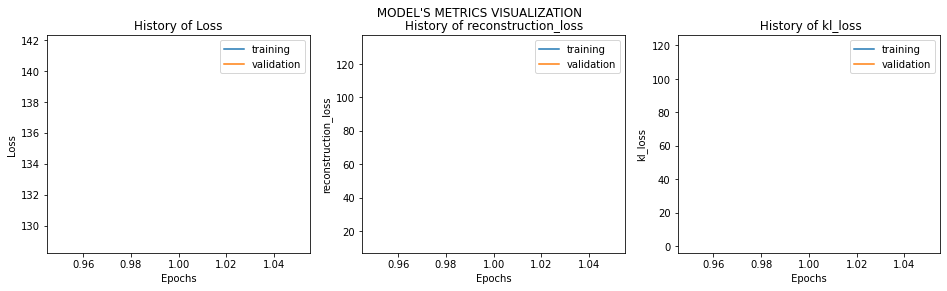

In [52]:
Train_Val_Plot(history.history['loss'],
               history.history['reconstruction_loss'],
               history.history['kl_loss'],
               history.history['val_val_loss'],
               history.history['val_val_reconstruction_loss'],
               history.history['val_kl_loss']
               )


In [ ]:
vae.save_weights('weights/vae.h5')

In [ ]:
import pickle

with open('trainHistoryDict.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
import pandas as pd

object = pd.read_pickle(r'trainHistoryDict.txt')


In [ ]:
Train_Val_Plot(object['loss'],
              object['reconstruction_loss'],
             object['kl_loss']
               )

In [ ]:
#vae(np.zeros((1,50,50,3)))
#vae.built = True
#vae.load_weights('weights/vae.h5')

In [ ]:
#p = vae.predict(train_x[:1000])
p = vae.predict(train_x)

In [ ]:
plt.imshow(train_x[0])
plt.show()

In [ ]:
plt.imshow(p[0])
plt.show()

In [ ]:
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        ax[0][i].imshow(np.reshape(y_true[i], (50, 50, 3)), aspect='auto')
        ax[1][i].imshow(np.reshape(y_pred[i], (50, 50, 3)), aspect='auto')
    plt.tight_layout()

In [ ]:
plot_predictions(train_x[:100], p)

In [ ]:
# Scatter with images instead of points
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
img_size = 50
def imscatter(x, y, ax, imageData, zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        # Convert to image
        img = imageData[i]*255.
        img = img.astype(np.uint8).reshape([img_size,img_size,3])
        #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        # Note: OpenCV uses BGR and plt uses RGB
        image = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

In [ ]:
#https://github.com/despoisj/LatentSpaceVisualization/blob/master/visuals.py
from sklearn import manifold

def computeTSNEProjectionOfLatentSpace(X, X_encoded, display=True, save=True):
    # Compute latent space representation
    print("Computing latent space projection...")
    #X_encoded = encoder.predict(X)

    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded)

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(15, 15))
        ax = fig.add_subplot(111, facecolor='black')
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.5)
        if save:
            fig.savefig('img/t-SNE-embedding_vae_latent:{}_epochs:{}_beta:{}.png'.format(latent_dim, epochs, beta_coeff))
        plt.show()
    else:
        return X_tsne

In [ ]:
X_encoded = vae_encoder.predict(train_x[:1000])[0]
X_encoded.shape
#need to reshape for TSNE
#X_encoded_flatten = X_encoded.reshape(-1,25*25*3)
#X_encoded_flatten.shape
X_encoded_flatten = X_encoded
X_encoded_flatten.shape

In [ ]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_encoded_flatten)

In [ ]:
computeTSNEProjectionOfLatentSpace(train_x[:1000,], X_encoded_flatten, display=True, save=True)

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['y'] = train_y_label[:1000]
df['comp-1'] = X_tsne[:,0]
df['comp-2'] = X_tsne[:,1]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
colors = {0:'blue', 1:'red'}

ax.scatter(df["comp-1"], df["comp-2"], c=df['y'].map(colors), label=colors) 
ax.legend()
plt.show()

In [ ]:
def computeTSNEProjectionOfPixelSpace(X, display=True):
    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X.reshape([-1, 50* 50* 3]))

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(15, 15))
        ax = fig.add_subplot(111, facecolor='black')
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.5)
        fig.savefig('img/t-SNE_original_space.png')
        plt.show()
    else:
        return X_tsne

In [ ]:
#computeTSNEProjectionOfPixelSpace(train_x[:1000], display=True)

In [ ]:
def getReconstructedImages(X, encoder, decoder):
    img_size = 50
    nbSamples = X.shape[0]
    nbSquares = int(math.sqrt(nbSamples))
    nbSquaresHeight = 2*nbSquares
    nbSquaresWidth = nbSquaresHeight
    resultImage = np.zeros((nbSquaresHeight*img_size,int(nbSquaresWidth*img_size/2),X.shape[-1]))

    reconstructedX = decoder.predict(encoder.predict(X)[2])

    for i in range(nbSamples) :     # 
        original = X[i]
        reconstruction = reconstructedX[i]
        rowIndex = i%nbSquaresWidth
        columnIndex = int((i-rowIndex)/nbSquaresHeight)
        resultImage[rowIndex*img_size:(rowIndex+1)*img_size,columnIndex*2*img_size:(columnIndex+1)*2*img_size,:] = np.hstack([original,reconstruction])

    return resultImage



In [ ]:
# Reconstructions for samples in dataset
def visualizeReconstructedImages(X_train, X_test, encoder, decoder, save=False):
    trainReconstruction = getReconstructedImages(X_train, encoder, decoder)
    testReconstruction = getReconstructedImages(X_test, encoder, decoder)

    if not save:
        print("Generating 10 image reconstructions...")

    result = np.hstack([trainReconstruction,
            np.zeros([trainReconstruction.shape[0],5,
            trainReconstruction.shape[-1]]),
            testReconstruction])
    result = (result*255.).astype(np.uint8)

    if save:
        fig, _ = plt.subplots(figsize=(15, 15))
        plt.imshow(result)
        fig.savefig('img/vae_reconstructions_latent:{}_epochs:{}_beta:{}.png'.format(latent_dim, epochs, beta_coeff))
    else:
        plt.show()


In [ ]:
visualizeReconstructedImages(train_x[:100], test_x[:100],vae_encoder, vae_decoder, save = True)

In [ ]:
#noise = np.random.normal(size=(1, 25, 25, 3))
#noise = noise.reshape((1,25,25,3))
#decoded = vae_decoder.predict(noise)
#plt.imshow((decoded[0]*255.).astype(np.uint8))

In [ ]:
def generate_images(decoder):    
    _, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(2):
        for j in range(10):
            noise = []
            for k in range(0,1875):
                noise.append( random.randint(-1.5, 1.5) )
                
            noise = np.array(noise)
            noise = noise.reshape(1, 1000)

            decoded = vae_decoder.predict(noise)
            ax[i][j].imshow(decoded[0], aspect='auto')
       
    plt.tight_layout()

In [ ]:
def generate_images(decoder):    
    _, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(2):
        for j in range(10):
            noise = np.random.normal(loc=0, scale = 1, size=vae_decoder.input_shape[1])
                
            noise = np.array(noise)
            noise = noise.reshape(1, 1000)

            decoded = vae_decoder.predict(noise).squeeze()
            ax[i][j].imshow( (decoded*255.).astype(np.uint8) )
       
    plt.tight_layout()

In [ ]:
def generate_images(decoder):    
    fig, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(2):
        for j in range(10):
            noise = np.random.normal(loc=0, scale = 1, size=vae_decoder.input_shape[1])
                
            noise = np.array(noise)
            noise = noise.reshape(1, 1000)

            decoded = vae_decoder.predict(noise).squeeze()
            ax[i][j].imshow( (decoded*255.).astype(np.uint8) )
    fig.savefig('img/vae_generations_latent:{}_epochs:{}_beta:{}.png'.format(latent_dim, epochs, beta_coeff))   
    plt.tight_layout()

In [ ]:
generate_images(vae_decoder)

In [ ]:
#Shows linear inteprolation in image space vs latent space
def visualizeInterpolation(start, end, encoder, decoder, save=False, nbSteps=5):
    print("Generating interpolations...")

    # Create micro batch
    X = np.array([start, end])

    # Compute latent space projection
    latentX = encoder.predict(X)[2]
    latentStart, latentEnd = latentX

    # Get original image for comparison
    startImage, endImage = X

    vectors = []
    normalImages = []
    #Linear interpolation
    alphaValues = np.linspace(0, 1, nbSteps)
    for alpha in alphaValues:
        # Latent space interpolation
        vector = latentStart*(1-alpha) + latentEnd*alpha
        vectors.append(vector)
        # Image space interpolation
        blendImage = cv2.addWeighted(startImage, 1-alpha, endImage, alpha, 0)
        normalImages.append(blendImage)

    # Decode latent space vectors
    vectors = np.array(vectors)
    reconstructions = decoder.predict(vectors)

    # Put final image together
    resultLatent = None
    resultImage = None

    for i in range(len(reconstructions)):
        interpolatedImage = normalImages[i]*255
        interpolatedImage = cv2.resize(interpolatedImage,(50,50))
        interpolatedImage = interpolatedImage.astype(np.uint8)
        resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage,interpolatedImage])

        reconstructedImage = reconstructions[i]*255.
        reconstructedImage = reconstructedImage.reshape(50,50,3)
        #reconstructedImage = cv2.resize(reconstructedImage,(50,50))
        reconstructedImage = reconstructedImage.astype(np.uint8)
        resultLatent = reconstructedImage if resultLatent is None else np.hstack([resultLatent,reconstructedImage])

    result = np.vstack([resultImage,resultLatent])
    fig, ax = plt.subplots(figsize=(18, 4))
    ax.imshow(result)
    plt.tight_layout()
       #    plt.imshow(result)
    if save:
        
        fig.savefig('img/vector_interpolation_epochs:{}_beta:{}.png'.format(epochs, beta_coeff))
    


In [ ]:
visualizeInterpolation(train_x[random.randint(0,train_x.shape[0])], train_x[random.randint(0, train_x.shape[0])],
                     vae_encoder, vae_decoder, save=False, nbSteps=10)

In [ ]:
def send_email_pdf_figs(path_to_pdf, subject, message, destination, password_path=None):
    ## credits: http://linuxcursor.com/python-programming/06-how-to-send-pdf-ppt-attachment-with-html-body-in-python-script
    from socket import gethostname
    #import email
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    import smtplib
    import json

    server = smtplib.SMTP('smtp-mail.outlook.com', 587)
    server.starttls()

    server.login('nicolas.derus2@unibo.it', 'Epiphone1111-')
    # Craft message (obj)
    msg = MIMEMultipart()

    message = f'{message}\nSend from Hostname: {gethostname()}'
    msg['Subject'] = subject
    msg['From'] = 'nicolas.derus2@unibo.it'
    msg['To'] = destination
    # Insert the text to the msg going by e-mail
    msg.attach(MIMEText(message, "plain"))
    # Attach the pdf to the msg going by e-mail

    for path in path_to_pdf:    
        with open(path, "rb") as f:
            #attach = email.mime.application.MIMEApplication(f.read(),_subtype="pdf")
            attach = MIMEApplication(f.read(),_subtype="pdf")
            attach.add_header('Content-Disposition','attachment',filename=str(path))
            msg.attach(attach)
    # send msg
    server.send_message(msg)

In [ ]:
path_to_pdf = ('/home/PERSONALE/nicolas.derus2/HistoDL/img/vae_loss_latent:{}_epochs:{}_beta:{}.png'.format(latent_dim, epochs, beta_coeff), #loss
                '/home/PERSONALE/nicolas.derus2/HistoDL/img/t-SNE-embedding_vae_latent:{}_epochs:{}_beta:{}.png'.format(latent_dim, epochs, beta_coeff), #embedding
                '/home/PERSONALE/nicolas.derus2/HistoDL/img/vae_reconstructions_latent:{}_epochs:{}_beta:{}.png'.format(latent_dim, epochs, beta_coeff), #reconstuctions
                '/home/PERSONALE/nicolas.derus2/HistoDL/img/vae_generations_latent:{}_epochs:{}_beta:{}.png'.format(latent_dim, epochs, beta_coeff))

In [ ]:
send_email_pdf_figs(path_to_pdf, 'Run completed!', 'HistoDL ', 'nrderus1@gmail.com', password_path=None)

In [ ]:
#loss
#send_email_pdf_figs('/home/PERSONALE/nicolas.derus2/HistoDL/img/vae_loss_latent:{}_epochs:{}_beta:{}.png'.format(latent_dim, epochs, beta_coeff), 'Run completed!', 'HistoDL - Embedding', 'nrderus1@gmail.com', password_path=None)

In [ ]:
#embedding
#send_email_pdf_figs('/home/PERSONALE/nicolas.derus2/HistoDL/img/t-SNE-embedding_vae_latent:{}_epochs:{}_beta:{}.png'.format(latent_dim, epochs, beta_coeff), 'Run completed!', 'HistoDL - Embedding', 'nrderus1@gmail.com', password_path=None)
